# Modele de détection "YOLO": préprocessing et entrainement du modèle


Finalement nous avons tenté d'implémenter un modèle prédisant simulatément la présence et la bounding box associés aux 4 formes nuageuses.

Ce notebook présente l'implémentation d'un modèle de type "YOLO" (Yon only look once). Nous avons repris l'approche classique du YOLO pour à la fois détecter la présence des formes, et calculer les coordonnées et tailles des bounding boxes associées.

Dans ce notebook, nous avons effectué l'étape de préprocessing des données, puis la construction, l'entrainement et la sauvegarde du modèle.
Les résultats seront analysés dans un autre notebook dédié.



## I. Chargement et préprocessing des données

Nous allons construire un modèle YOLO associé à une grille de dimension 5 x 5.
Le modèle est construit de manière à prédire pour chaque cellule:
- la présence ou non d'un objet (1 variable)
- la classe de cet objet: 4 labels sont possibles Fish, Flower, Gravel, Sugar (4 variables)
- les dimensions de la bounding box correspondante (4 variables)

Notre cible prendra donc la forme d'un tenseur de taille 25 x 9.


### I.A Chargement des données

Nous partons du fichier csv contenant les coordonnées des bounding boxes sous la forme (xmin, xmax, ymin, ymax) pour chaque couple (Image, forme). Dans un premier temps, nous transformons de façon classique les coordonnées au format (X,Y,w,h), puis, pour chaque image, nous allons construire le tenseur cible à partir des coordonnées des bounding boxes (entre une et quatre) associées à cette image.

In [1]:
import pandas as pd
data_df = pd.read_csv('train_with_bbox_finalversion.csv').drop(['Unnamed: 0'],1)
print(data_df.shape)
data_df.head()

(11822, 6)


,ImageId,Label,xmin,ymin,xmax,ymax
0,0011165.jpg,Fish,189,318,1183,1255
1,0011165.jpg,Flower,968,314,2094,1367
2,002be4f.jpg,Fish,167,10,2086,891
3,002be4f.jpg,Flower,956,879,2097,1398
4,002be4f.jpg,Sugar,48,295,944,645


In [2]:
larg = 2100
haut = 1400
data_df['xmoy'] = (data_df.xmax + data_df.xmin)/2/larg
data_df['ymoy'] = (data_df.ymax + data_df.ymin)/2/haut
data_df['w'] = (data_df.xmax - data_df.xmin)/larg
data_df['h'] = (data_df.ymax - data_df.ymin)/haut
data_df['bbox'] = data_df.apply(lambda x : [x.xmoy,x.ymoy,x.w,x.h], axis = 1)

### I.B Préprocessing: calcul du tenseur cible "y_true"

Nous allons créer un dataframe dédié contenant d'une part le chemin de chaque image du jeu de test (colonne 1) et d'autre part le tenseur cible(colonne 2). Pour calculer le tenseur, nous avons adapter la méthode "convert_target" qui permet, en partant de l'information d'un label et des coordonnées de la bounding box associée, de renvoyer le tenseur 25x9 correspondant. 
Nous avons créé une seconde méthode "convert_multi_target" pour aggréger, pour une image donnée, les tenseurs "unitaires" pour chacune des formes (qui correspond donc à une ligne dans le dataframe d'origine) afin d'obtenir le tenseur cible.

In [7]:
images_names = data_df['ImageId'].unique()
target_data = pd.DataFrame(images_names, columns = ['ImageId'])
target_data['ImageId']= target_data.apply(lambda x : 'train_images/' + x.ImageId, 1)
target_data=target_data[target_data['ImageId'] != "train_images/e5f2f24.jpg"]
target_data=target_data[target_data['ImageId'] != "train_images/c26c635.jpg"]
target_data.head()

,ImageId
0,train_images/0011165.jpg
1,train_images/002be4f.jpg
2,train_images/0031ae9.jpg
3,train_images/0035239.jpg
4,train_images/003994e.jpg


In [8]:
import tensorflow as tf
import numpy as np

output_shape = (5, 5)

def convert_target(bboxes,Label, output_shape, nb_classes):
    y_target = np.zeros([output_shape[0], output_shape[1], 1+4+nb_classes])
    lx=1/output_shape[1]
    ly=1/output_shape[0]
    #print(Label)
    # on identifie la classe parcourue
    if Label == 'Fish':
        c=5
    elif Label == 'Flower':
        c=6
    elif Label == 'Gravel':
        c=7
    else:
        c=8

    x, y, w, h = bboxes
    idx_x = int(x//lx)
    idx_y = int(y//ly)
    # Presence of object
    y_target[idx_y, idx_x, 0] = 1
    # Coordinate x
    y_target[idx_y, idx_x, 1] = 2*(x/lx - (idx_x+0.5))
    # Coordinate y
    y_target[idx_y, idx_x, 2] = 2*(y/ly - (idx_y+0.5))
    # Coordinate w
    y_target[idx_y, idx_x, 3] = w
    # Coordinate h
    y_target[idx_y, idx_x, 4] = h
    # Class of object
    #print(c)
    y_target[idx_y, idx_x, c] = 1
    #print(y_target.shape)   
    return y_target.reshape([-1, 1+4 +nb_classes])
    #return y_target

def multi_convert_target(ImageId, df):
    #print(ImageId)
    #print(ImageId[13:])
    data = df[df['ImageId']==ImageId[13:]]
    #print(data.head())
    data['target'] = data.apply(lambda x: convert_target(x.bbox,x.Label,output_shape,4),axis = 1)
    y_multi_target = data['target'].sum()
    return y_multi_target
    

Nous pouvons appliquer cette fonction convert_multi_target pour créer la colonne correspondante dans target_data.

In [9]:
target_data['y_target'] = target_data['ImageId'].apply(lambda x: multi_convert_target(x,data_df))
target_data.head()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ImageId,y_target
0,train_images/0011165.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
1,train_images/002be4f.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
2,train_images/0031ae9.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
3,train_images/0035239.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
4,train_images/003994e.jpg,"[[1.0, 0.14761904761904754, 0.825, 0.210476190..."


On vérifie que l'on a pas mis plusieurs formes dans une même cellule de grille. Pour cela on définit une fonction qui nous indique si ça se produit et on supprime les images qui contiennent plusieurs images par cellule, car inadaptées à la formulation de notre problème (environs 10% des images en grille 5 x 5).

In [10]:
def check_validity(y_target):
    check = max(y_target[:,0])
    if check > 1:
        return 1
    else:
        return 0

#check_validity(yy)

target_data['check_grid'] = target_data['y_target'].apply(check_validity)

invalid_data = target_data[target_data['check_grid'] == 1]
print("nombre images invalides (2 formes dans une cellule): ",invalid_data.shape[0])


nombre images invalides (2 formes dans une cellule):  534


Nous supprimons ces données du dataframe.

In [11]:
target_data = target_data[target_data['check_grid'] == 0]
target_data = target_data.drop(['check_grid'], axis = 1)
target_data.head()

,ImageId,y_target
0,train_images/0011165.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
1,train_images/002be4f.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
2,train_images/0031ae9.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
3,train_images/0035239.jpg,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]..."
4,train_images/003994e.jpg,"[[1.0, 0.14761904761904754, 0.825, 0.210476190..."


Après vérification en recalculant la distribution des images par nombre de formes présentes, il ne semble pas y avoir d'images problématiques au moment où l'on projette sur la grille. désormais, nous allons définir une fonction permettant de visualiser les formes à partir du tenseur y_target correspondant.

## II. Definition des datasets entrainement et test

Nous allons à présent séparer nos données en jeu d'entraînement et jeu de validation, . Afin de pouvoir analyser les performances de notre modèle entraîné séparément (en le rechargeant) nous sauvegardons sous forme de fichier csv les données d'entraînement et de validation.

In [12]:
# split entrainement et validation
from sklearn.model_selection import train_test_split
target = target_data.y_target.values
target = np.vstack([np.expand_dims(x, 0) for x in target])
X_train_path, X_test_path, y_train, y_test = train_test_split(
                                target_data.ImageId.values,
                                target,
                                train_size=0.9, random_state=1234)

### II.A Fonctions utiles pour gérer les changements de format

Avant de réaliser l'export, nous définissons quelques fonctions techniques qui vont nous être utiles dans la suite:
- transform_netout permettra de faire un traitement nécessaire du tenseur cible avant de pouvoir l'interpréter
- generate_yolo_grid et process_xy sont des fonctions permettant de passer des coordonnées sur la grille (telles qu'exprimées dans le tenseur cible) aux coordonnées au format initiale (sur l'image), tel que nous le souhaitons.
- pred_bboxes est la fonction contenant le plus d'intelligence (donc de parti  pris): c'est une fonction qui prend en entrée le tenseur cible (25 x 9) et qui renvoie une liste de N vecteurs de longueur 9 (nos 9 variables d'intérêt), avec N = 1, 2, 3 ou 4. Chacun de ces vecteurs correspond à un couple Bounding bo/formex que nous aurons retenu pour l'image en fonction des différentes probabilités. 


In [245]:
import matplotlib.pyplot as plt

def transform_netout(y_pred_raw):
    y_pred_xy = (tf.nn.tanh(y_pred_raw[..., 1:3]))
    y_pred_wh = tf.sigmoid(y_pred_raw[..., 3:5])
    y_pred_conf = tf.sigmoid(y_pred_raw[..., :1])
    y_pred_class = tf.sigmoid(y_pred_raw[..., 5:9])
    return tf.concat([y_pred_conf, y_pred_xy, y_pred_wh,y_pred_class], -1)

def generate_yolo_grid(g):
    c_x = tf.cast(tf.reshape(tf.tile(tf.range(g), [g]), (1, g, g)), 'float32')
    c_y = tf.transpose(c_x, (0,2,1))
    return tf.stack([tf.reshape(c_x, (-1, g*g)), tf.reshape(c_y, (-1, g*g))] , -1)

c_grid = generate_yolo_grid(output_shape[0])

def proccess_xy(y_true_raw):
    y_true_xy = ((y_true_raw[..., 1:3]+1)/2 + c_grid)/output_shape[0]
    y_true_wh = y_true_raw[..., 3:5]
    y_true_conf = y_true_raw[..., :1]
    y_true_class = y_true_raw[..., 5:9]
    return tf.concat([y_true_conf, y_true_xy, y_true_wh,y_true_class], -1) 

def pred_bboxes(y, threshold):
    y_xy = tf.cast(y, tf.float32)
    y_xy = tf.expand_dims(y_xy, axis=0)
    y_xy = proccess_xy(y_xy)[0]
    #return y_xy
    bboxes =  sorted(y_xy.numpy(), key=lambda x: x[0], reverse=True)
    bboxes = np.array(bboxes)
    result = bboxes[bboxes[:,0]>threshold]
    #print("result avant ajust:", len(result))
    # on doit ajuster les valeurs pour assurer la présence de classes différentes
    if len(result)== 0:
        # dans ce cas il n'y a aucune box retenue, on doit en mettre une
        kmax = np.argmax(bboxes[:,0]) 
        result = bboxes[kmax,:].reshape([1,9])

    # pour chaque bbox on met toutes les probas de classe à 0 sauf la plus haute
    for k in range(len(result)):
        imax = np.argmax(result[k,5:])
        pmax = result[k,5+imax]
        result[k,5:]=0
        result[k,5+imax]=pmax
        # ensuite, on met la  l la proba de chaque classe à 1 pour celle qui a la proba max, et 0 pour les autres
        # pour éviter des doublons
    for i in range(4):
            kmax = np.argmax(result[:,5+i]*result[:,0])
            pmax = result[kmax,5+i]
            result[:,5+i]=0
            if pmax > 0:
                result[kmax,5+i]=1
        #enfin on vire les bbox qui ne prédisent plus de classes après notre post processing
    #print("result apres adjust", result)
    #result_final = []
    result_final = result[(result[:,5]+result[:,6]+result[:,7]+result[:,8])>0 ]
    #for k in range(len(result)):
        #print(element)
        #if not (np.max(result[k,5:]) == 0):
        #    result_final.append(result[k,:])
    #print(type(result_final))
    return result_final 



### II.B Export des données

Nous pouvons désormais exporter les données de test et de validation. Nous choisissons d'exporter les variables cibles non pas sous la forme de tenseur (qui pose des difficultés en terme de manipulation) mais sous forme simplifiées d'array de taille N x 9 avec N = 1,2,3 ou 4 (les N couples bounding box/forme correspondant à l'image).

In [247]:
#sauvegarde true bboxes pour data test
X_test_path.shape
y_test_list = []
for k in range(y_test.shape[0]):
    box = pred_bboxes(y_test[k],0.5)
    y_test_list.append(box)
df_y = pd.DataFrame(y_test_list,columns = ['true_bboxes'])
#print(df_y.shape)
df_path = pd.DataFrame(X_test_path, columns = ['ImageId'])
df_test = pd.concat([df_path, df_y], axis = 1)
df_test.to_csv('Test_set_yolo.csv')

#sauvegarde true bboxes pour data train
X_train_path.shape
y_train_list = []
for k in range(y_train.shape[0]):
    box = pred_bboxes(y_train[k],0.5)
    y_train_list.append(box)
#y_train_list = np.array(y_train_list)
df_y = pd.DataFrame(y_train_list,columns = ['true_bboxes'])
print(df_y.shape)
df_path = pd.DataFrame(X_train_path, columns = ['ImageId'])
df_train = pd.concat([df_path, df_y], axis = 1)
df_train.to_csv('Train_set_yolo.csv')
df_train.head()

(4507, 1)


,ImageId,true_bboxes
0,train_images/c65a8be.jpg,"[[1.0, 0.55785716, 0.23357144, 0.64428574, 0.4..."
1,train_images/f8a9d37.jpg,"[[1.0, 0.39761907, 0.6321429, 0.7438095, 0.735..."
2,train_images/9937e8a.jpg,"[[1.0, 0.5735714, 0.15928571, 0.33857143, 0.30..."
3,train_images/16c65fc.jpg,"[[1.0, 0.2695238, 0.41392857, 0.53333336, 0.37..."
4,train_images/4882d33.jpg,"[[1.0, 0.4285714, 0.50035715, 0.45142856, 0.97..."


### II.C Définition des tensorflow dataset

Nous pouvons à présent construire les dataset que nous utiliserons lors de l'entraînement.

In [18]:
#definition du dataset
batch_size = 24
def load_data(filepath, y, resize=(320,320)):
    im = tf.io.read_file(filepath)
    im = tf.image.decode_png(im, channels=3)
#     im_shape = tf.shape(im)
    im = tf.image.resize(im, resize)
    y_new = np.vstack([np.expand_dims(x, 0) for x in y])
    return im, y_new

dataset_train = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
#dataset_train = dataset_train.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)
dataset_train = dataset_train.map(lambda x, y : tf.py_function(load_data, [x, y], [tf.float32, tf.float32]), num_parallel_calls=-1).batch(int(batch_size))
dataset_test = tf.data.Dataset.from_tensor_slices((X_test_path, y_test))
#dataset_train = dataset_train.map(lambda x, y : [load_image(x), y], num_parallel_calls=-1).batch(32)
dataset_test = dataset_test.map(lambda x, y : tf.py_function(load_data, [x, y], [tf.float32, tf.float32]), num_parallel_calls=-1).batch(int(batch_size))


Nous pouvons à titre d'exmple visualiser sur quelques images la localisation des formes sur la grille (leur classe n'est pas précisée ici).

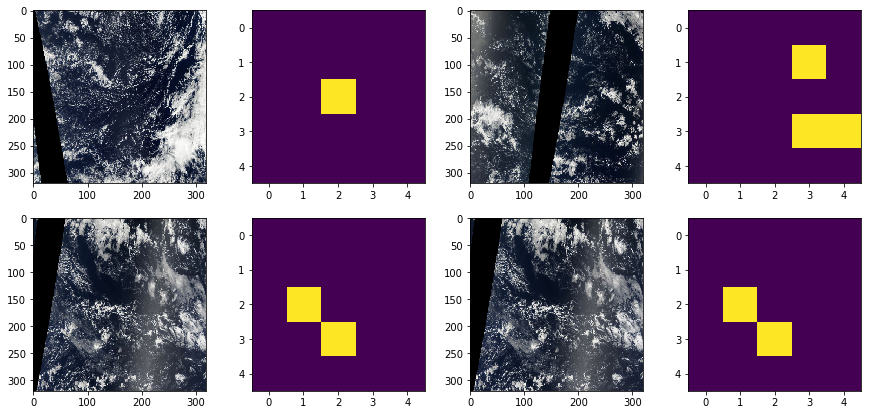

In [19]:
X_t, y_t = next(iter(dataset_test))
plt.figure(figsize=(15,7))
for j, i in enumerate(np.random.randint(0, batch_size, [4])):
    plt.subplot(2,4,2*j+1)
    plt.imshow(X_t[i].numpy().astype(int))
    plt.subplot(2,4,2*j+2)
    plt.imshow(y_t[i,:,0].numpy().reshape(output_shape))

## III. Construction du modèle


Nous allons à présent construire notre modèle.
Nous  utilisons un modèle pré-entraîné de type EfficientNetB0, auquel nous allons ajouter en sortie 5 couches denses.
Les images en entrée ont été redimensionnées en 320 x 320 pour des raisons pratiques par rapport aux dimensions de notre tenseur de sortie. Initialement toutes les couches de l'EfficientNetB0 sont freezées.

In [20]:
from tensorflow.keras.applications import EfficientNetB0
from keras.applications import VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, LeakyReLU, Dropout, Reshape, BatchNormalization
from tensorflow.keras import Sequential
from keras.layers.convolutional import MaxPooling2D

nb_class = 4

# Backbone
pretrained_model1 = EfficientNetB0(include_top=False, input_shape=(320,320,3))
pretrained_model2 = VGG19(input_shape=(320,320,3), include_top=False, weights="imagenet")
# Freeze the blackbone
for layer in pretrained_model1.layers:
    layer.trainable = False
for layer in pretrained_model2.layers:
    layer.trainable = False
model = Sequential()
# Feature extration part
#model.add(pretrained_model1) 
model.add(pretrained_model1) 
second_layer = MaxPooling2D(pool_size = (2, 2))
model.add(second_layer)
#pretrained_model2.summary()
model.add(Reshape([-1, 1280]))
#model.add(Reshape([-1, 512]))
# Regression Part
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5 + nb_class))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 1280)        0         
_________________________________________________________________
reshape (Reshape)            (None, 25, 1280)          0         
_________________________________________________________________
dense (Dense)                (None, 25, 512)           655872    
_________________________________________________________________
dropout (Dropout)            (None, 25, 512)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 25, 256)           131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0

## IV. Définition de la fonction de loss

Nous utilisons ici la définition usuelle de la fonction loss pour un YOLO, avec un terme lié à la classe, un terme lié aux coordonnées et un terme lié à la présence d'objet.

In [21]:

def class_loss(y_true, y_pred):
    # Vecteur de présence d'un objet
    y_true_conf = y_true[...,0]
    # Probabilité conditionelle des vrais objets
    y_true_class = y_true[...,5:9]#tf.one_hot(y_true[...,5], nb_class)
    
    # Probabilité conditionelle des prédictions
    y_pred_class = y_pred[...,5:]
    # Calcul de la fonction de perte
    class_loss = tf.reduce_sum(y_true_conf*tf.reduce_sum(tf.square(y_true_class - y_pred_class), axis=-1), axis=-1)
    return class_loss
# test loss for the prediction X_t
#class_loss(y_t, y_pred)

In [22]:
def coord_loss(y_true, y_pred):
    # Probabilty of object presence
    y_true_conf = y_true[...,0]
    
    # x and y loss for real object
    y_true_xy = y_true[...,1:3]
    y_pred_xy = y_pred[...,1:3]
    xy_loss = tf.reduce_sum(tf.reduce_sum(tf.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    
    # w and h loss for real object
    y_true_wh = y_true[...,3:5]
    y_pred_wh = y_pred[...,3:5]
    wh_loss = tf.reduce_sum(tf.reduce_sum(tf.square(tf.sqrt(y_true_wh) - tf.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)
    return xy_loss + wh_loss

# Coordinate loss for the prediction X_t
#coord_loss(y_t, y_pred)

In [23]:
lambda_noobj = 0.5

def object_loss(y_true, y_pred):
    # x and y loss for real object
    y_true_p = y_true[...,0]
    y_pred_p = y_pred[...,0]
    return tf.reduce_sum((lambda_noobj + (1-lambda_noobj)*y_true_p)*tf.square(y_true_p - y_pred_p), axis=-1)
# Coordinate loss for the prediction X_t
#object_loss(y_t, y_pred)

In [24]:
lambda_coord = 5
lambda_object = 1
lambda_class = 1
def global_loss(y_true, y_pred):
    # Convert input
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = transform_netout(y_pred)
    loss_class = class_loss(y_true, y_pred)
    loss_coordinate = coord_loss(y_true, y_pred)
    loss_object = object_loss(y_true, y_pred)
    return lambda_object*loss_object + lambda_coord*loss_coordinate + lambda_class * loss_class
# Coordinate loss for the prediction X_t
#global_loss(y_t, y_pred)

## V. Compilation et entraiment du modele

Nous définissons quelque callback, compilons le modèle et faisons un premier entrainement de 20 epochs avec toutes les couches freezées pour l'EfficientNetB0. Ensuite nous ferons 2 autres entraînements, l'un avec 20 couches defreezées, l'autre avec 40 couches defreezées.

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

model.compile(optimizer=Adam(1e-3), loss=global_loss)




# Save automatically the weights
checkpoint = callbacks.ModelCheckpoint(filepath = 'model', 
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       mode = 'min',
                                       save_freq = 'epoch')

# Callback to reduce automatically the learning rate.
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience=2,
                                         factor=0.1,
                                         verbose=2,
                                         mode='min')

early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 3,
                                         mode = 'min',
                                         restore_best_weights = True) 

In [59]:
for layer in pretrained_model1.layers:
    layer.trainable = False
history = model.fit_generator(dataset_train,validation_data = dataset_test, verbose=1, epochs=20, callbacks = [early_stopping, lr_plateau, checkpoint])
# serialize model to JSON
model_json = model.to_json()


Epoch 1/20
188/188 [==============================] - 179s 950ms/step - loss: 11.2380 - val_loss: 10.2066
Epoch 2/20
188/188 [==============================] - 168s 895ms/step - loss: 10.2731 - val_loss: 9.9800
Epoch 3/20
188/188 [==============================] - 168s 893ms/step - loss: 9.9865 - val_loss: 9.8208
Epoch 4/20
188/188 [==============================] - 168s 895ms/step - loss: 9.7706 - val_loss: 9.6067
Epoch 5/20
188/188 [==============================] - 168s 895ms/step - loss: 9.5991 - val_loss: 9.5616
Epoch 6/20
188/188 [==============================] - 169s 896ms/step - loss: 9.4063 - val_loss: 9.3637
Epoch 7/20
188/188 [==============================] - 168s 894ms/step - loss: 9.2855 - val_loss: 9.4082
Epoch 8/20
188/188 [==============================] - 168s 895ms/step - loss: 9.1884 - val_loss: 9.2785
Epoch 9/20
188/188 [==============================] - 168s 895ms/step - loss: 9.0823 - val_loss: 9.3241
Epoch 10/20
188/188 [==============================] - ETA: 0

Une fois ce premier entraînement effectué, tentons de defreezer les 20 dernières couches puis réentraînons pendant 10 epochs le modèle, pour voir si l'entrainement permet de surmonter le problème d'overfitting que l'on constate en l'état (la Val loss ne parvenant pas à descendre en dessous de 9 contrairement à la train loss).

In [61]:
n_layer = 216
for layer in pretrained_model1.layers[:n_layer]:
    layer.trainable = False
for layer in pretrained_model1.layers[n_layer:]:
    layer.trainable = True
model.summary()
model.compile(optimizer=Adam(1e-3), loss=global_loss)
history2 = model.fit_generator(dataset_train,validation_data = dataset_test, verbose=1, epochs=10, callbacks = [early_stopping, lr_plateau, checkpoint])
model_json = model.to_json()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 1280)        0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 25, 1280)          0         
_________________________________________________________________
dense_15 (Dense)             (None, 25, 512)           655872    
_________________________________________________________________
dropout_12 (Dropout)         (None, 25, 512)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 25, 256)           131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 25, 256)          

Ayant defreezé les 20 dernières couches du EfficientNet nous avons gagné un point sur la val_loss, mais nous avons été aussi rapidement confronté au problème d'overfitting. Nous allons effectuer un dernier entraînement en defreezant les 20 couches suivantes.

In [63]:
n_layer = 196
for layer in pretrained_model1.layers[:n_layer]:
    layer.trainable = False
for layer in pretrained_model1.layers[n_layer:]:
    layer.trainable = True
model.summary()
model.compile(optimizer=Adam(1e-3), loss=global_loss)
history3 = model.fit_generator(dataset_train,validation_data = dataset_test, verbose=1, epochs=10, callbacks = [early_stopping, lr_plateau, checkpoint])
model_json = model.to_json()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 10, 10, 1280)      4049571   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 1280)        0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 25, 1280)          0         
_________________________________________________________________
dense_15 (Dense)             (None, 25, 512)           655872    
_________________________________________________________________
dropout_12 (Dropout)         (None, 25, 512)           0         
_________________________________________________________________
dense_16 (Dense)             (None, 25, 256)           131328    
_________________________________________________________________
dropout_13 (Dropout)         (None, 25, 256)          

### Sauvegarde du modèle

In [62]:
with open("model4_YOLO.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model4_YOLO.h5")
print("Saved model to disk")

Saved model to disk


## VI. Performance du modèle

Nous visualisons sous forme de graphe l'évolution des loss et val_loss au cours du temps. 

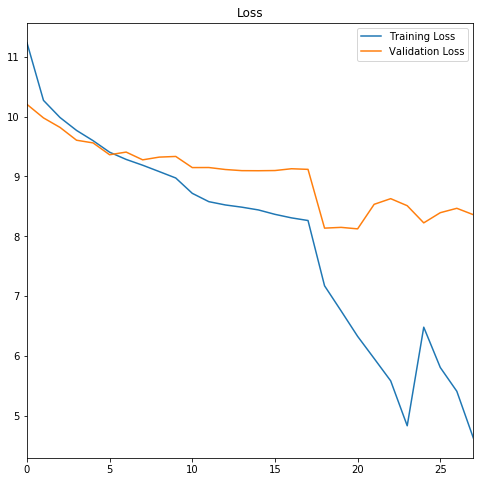

In [65]:
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

loss = loss1 + loss2 + loss3
val_loss = val_loss1 + val_loss2 + val_loss3

n_steps = 18+6+4
epochs_range = range(n_steps) # fonction pour récupérer le nbre d'epochs ?
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.xlim(0,n_steps-1)
plt.title('Loss')
plt.show()

## VII. Analyse des résultats

On peut alors faire notre prédiction pour l'ensemble des images de nos données. Nous commençons par recharger le jeu d'entraînement précédemment sauvegardé, ainsi que les modèles.

In [278]:
json_file = open('model4_YOLO.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("model4_YOLO.h5")

In [279]:
df_test = pd.read_csv('Test_set_yolo.csv')#, converters={'true_bboxes': from_np_array})
df_test.head()

,Unnamed: 0,ImageId,true_bboxes
0,0,train_images/985d5aa.jpg,[[1. 0.5519048 0.7482143 0.29142857 ...
1,1,train_images/e69a5fa.jpg,[[1. 0.24571428 0.2657143 0.49142858 ...
2,2,train_images/4736d30.jpg,[[1. 0.23904762 0.505 0.45904762 ...
3,3,train_images/1e40a05.jpg,[[1. 0.6742857 0.6571428 0.47238097 ...
4,4,train_images/6d0aa4a.jpg,[[1. 0.325 0.79285717 0.64238095 ...


### VII.1 Visualisation de quelques formes

Pour analyser la qualité de prédiction de notre modèle nous commençons par définir quelques méthodes permettant de visualiser les bounding boxes prédites, et la testons sur quelques images.

In [256]:
# methode permettant de charger une image

@tf.function
def load_image(filepath, resize=(320,320)):
    im = tf.io.read_file( filepath)
    im = tf.image.decode_png(im, channels=3)
    return tf.image.resize(im, resize)


# methodes permettant de visualiser une bbox individuelle
def show_bounding_box(im, bbox, normalised=True, Color='r', Label = None):
    # Signification de bbox
    x, y, w, h = bbox
    # Convertir les cordonées (x,y,w,h) en (x1,x2,y1,y2)
    x1=x-w/2
    x2=x+w/2
    y1=y-h/2
    y2=y+h/2    
    # redimensionner en cas de normalisation
    if normalised:
        x1=x1*im.shape[1]
        x2=x2*im.shape[1]
        y1=y1*im.shape[0]
        y2=y2*im.shape[0]       
    # Afficher l'image
    plt.imshow(im)    
    # Afficher la bounding box
    plt.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1],color = Color, label = Label)     
    plt.legend()

    
# methode renvoyant pour une image donnée (argument path) le vecteur prédit par notre modèle
def compute_y_pred(imgpath,model, resize=(320,320)):
    im = tf.io.read_file(imgpath)
    im = tf.image.decode_png(im, channels=3)
#     im_shape = tf.shape(im)
    im = tf.image.resize(im, resize)
    pred = model(np.array([im], dtype=np.float32))[0]
    pred = transform_netout(pred)
    #bboxes_pred = pred_bboxes(pred)
    #print(bboxes_pred)
    return pred

# Visualisation à partir du path de l'image et du tenseur prédit (ou cible) passé en argument
def show_img_from_tensor(imgpath, pred, threshold=0.4,resize=(320,320)):
    im = tf.io.read_file(imgpath)
    im = tf.image.decode_png(im, channels=3)
#     im_shape = tf.shape(im)
    im = tf.image.resize(im, resize)
    bboxes = pred_bboxes(pred, threshold)
    #print(bboxes)
    bboxes = np.matrix(bboxes)
    #print(bboxes)
    plt.imshow(im/255)
    for i in range(bboxes.shape[0]):       
        if bboxes[i,5] == 1:
            col = 'r'
            lab = 'Fish'
        if bboxes[i,6] == 1:
            col = 'b'
            lab = 'Flower'
        if bboxes[i,7] == 1:
            col = 'g'
            lab = 'Gravel'
        if bboxes[i,8] == 1:
            col = 'y'
            lab = 'Sugar'
        bbox = bboxes[i,1], bboxes[i,2], bboxes[i,3], bboxes[i,4] 
        show_bounding_box(im/255, bbox, Color = col,Label = lab)

# Visualisation à partir du path de l'image et des bboxes directement passées en argument
def show_img_from_bboxes(imgpath, bboxes,resize=(320,320)):
    im = tf.io.read_file(imgpath)
    im = tf.image.decode_png(im, channels=3)
#     im_shape = tf.shape(im)
    im = tf.image.resize(im, resize)
    plt.imshow(im/255)
    for i in range(bboxes.shape[0]):       
        if bboxes[i,5] == 1:
            col = 'r'
            lab = 'Fish'
        if bboxes[i,6] == 1:
            col = 'b'
            lab = 'Flower'
        if bboxes[i,7] == 1:
            col = 'g'
            lab = 'Gravel'
        if bboxes[i,8] == 1:
            col = 'y'
            lab = 'Sugar'
        bbox = bboxes[i,1], bboxes[i,2], bboxes[i,3], bboxes[i,4] 
        #bbox = bbox.reshape((1,4))
        #print(bbox)
        show_bounding_box(im/255, bbox, Color = col,Label = lab)

Appliquons notre modèle sur 4 images au hasard (du jeu de test) et comparons nos prédictions avec le résultat attendu.

In [266]:
def compare_predictions_multi(df,model):
    '''
    Methode qui reçoit en argument 
    2)un dataframe contenant 
        dans la premiere colonne le path d'une image 
        dans sa deuxième colonne les vecteurs decrivant les bounding boxes exactes (entre 1 et 4 vecteurs à 9 variables)
    3) un modele
    la methode choisit 4affiche les boîtes exactes avec leurs labels, ainsi que les boîtes prédites
    '''
    #bbox = []
    plt.figure(figsize = (20,10))
    for j, index in enumerate(np.random.randint(0, df.shape[0], [4])):        
        #image choisie au hasard
        img_name = df.iloc[index,1]
        # on recupere dans les données chargées les bounding boxes attendues
        bboxform = df.iloc[index,2]
        bboxform = np.matrix(bboxform)
        size = int(bboxform.shape[1]/9)
        bboxform = bboxform.reshape((size,9))
        #bbox.append(bboxform)        
        plt.subplot(2,4,2*j+1)
        # on affiche les bounding boxes attendues
        title = 'TRUE - ' + img_name[12:]
        plt.title(title)
        show_img_from_bboxes(img_name, bboxform)
        # on prédit les bounding boxes avec notre modele
        y_pred = compute_y_pred(img_name,model)#print(y_pred)
        plt.subplot(2,4,2*j+2)
        title = 'PREDICTED - ' + img_name[12:]
        plt.title(title)
        show_img_from_tensor(img_name,y_pred,threshold = 0.3)
        
        

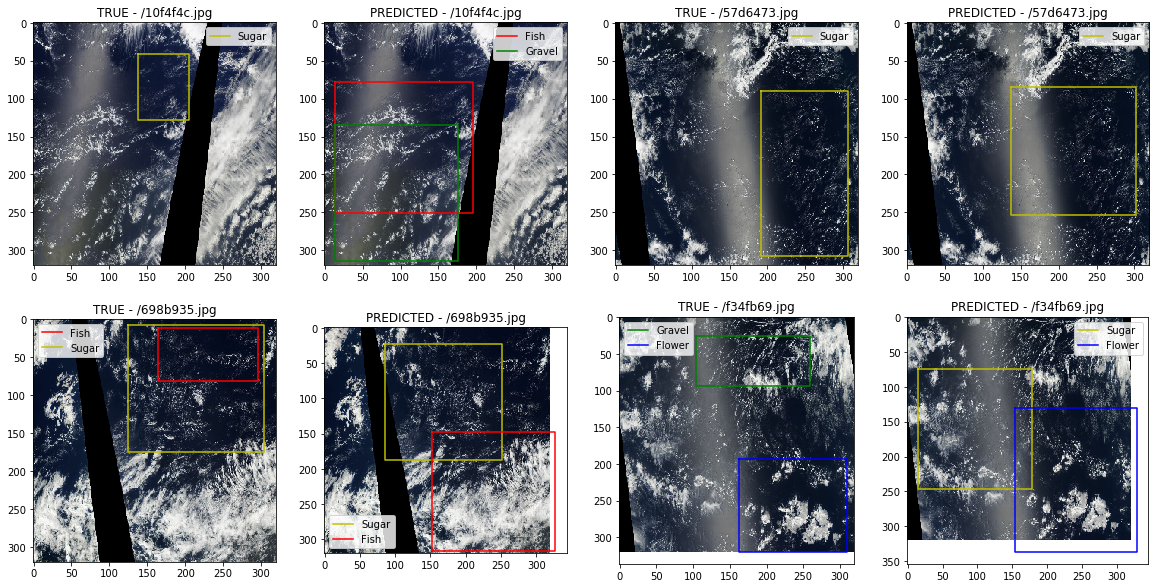

In [280]:
compare_predictions_multi(df_test,model)
#df_test.head()

In [269]:
def compare_prediction_mono(index, df_test, model):
    '''
    Methode qui reçoit en argument 
    1) un indice
    2)un dataframe contenant 
        dans la premiere colonne le path d'une image 
        dans sa deuxième colonne les vecteurs decrivant les bounding boxes exactes (entre 1 et 4 vecteurs à 9 variables)
    3) un modele
    la methode affiche les boîtes exactes avec leurs labels, ainsi que les boîtes prédites
    '''
# on identifie l'image et on recupere les bboxes correspondantes
    img_name = df_test.iloc[index,1]
    img = load_image(img_name)
# on remet en forme les bboxes cibles
    bbox_true = df_test.iloc[index,2]
    bbox_true = np.matrix(bbox_true)
    size = int(bbox_true.shape[1]/9)
    bbox_true = bbox_true.reshape((size,9))
    plt.figure(figsize = (12,6))
    # on visualise les bboxes cibles
    plt.subplot(1,2,1)
    title = "TRUE - " + img_name
    show_img_from_bboxes(img_name, bbox_true)
    plt.title(title)
    # on predit le tenseur cible
    y_pred = compute_y_pred(img_name,model)
    plt.subplot(1,2,2)
    title = "PREDICT - " + img_name
    # on visualise les bboxes predites correspondantes
    show_img_from_tensor(img_name,y_pred,threshold = 0.3)
    plt.title(title)
    plt.show()
        
    

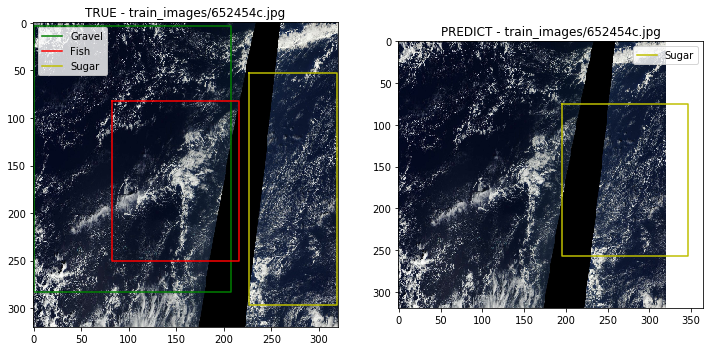

In [276]:
# choix d'un indice au hasard
index = np.random.randint(0,df_test.shape[0])
compare_prediction_mono(index,df_test,model)

#301
#1311
#653
#4057
#305
#5380
#2541
#3852
#002be4f      
#f32724b 
#a996e6f.jpg
#47b2950.jpg
#76807a8.jpg
#f32724b.jpg tout noir ou presque
#good 1659 --> pas mal 
#good 3553 b3e0e2c.jpg